In [3]:
import numpy as np
import matplotlib.pylab as plt
import pandas as pd

from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle

plt.rc('text', usetex=True)
plt.rc('font',**{'family':'sans-serif','serif':['Palatino']})
figSize  = (12, 8)
fontSize = 20

### Data and Covariance

In [ ]:
data = np.loadtxt('data/KV450_xi_pm_cut_to_cut_values_5zbins.dat', delimiter='\t')

In [ ]:
cov = np.loadtxt('data/Cov_mat_inc_m_cut_to_cut_values_5zbins.dat', delimiter='\t')

In [ ]:
ndata = data.shape[0]

In [ ]:
covmat = cov[:,-1].reshape(ndata, ndata)
var = np.diag(covmat)

### Plot Covariance Matrix

In [ ]:
new_cov = np.zeros((ndata, ndata))

for i in range(ndata):
	for j in range(ndata):
		new_cov[i,j] = covmat[i,j]/np.sqrt(covmat[i,i]*covmat[j,j])

In [ ]:
fig, ax = plt.subplots(figsize = (8,8))

heatmap = ax.pcolor(new_cov, cmap=plt.cm.gist_heat.reversed())
cbar = plt.colorbar(heatmap, fraction = 0.05)
cbar.set_label(r'$\frac{\mathbf{C}_{ij}}{\sqrt{\mathbf{C}_{ii}\mathbf{C}_{jj}}}$',size=18)
cbar.ax.tick_params(labelsize=18) 
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

# plt.savefig('data_cov.pdf', bbox_inches='tight')
plt.show()

### Theoretical Modelling

In [ ]:
import cosmology.weaklensing as cw
import setpriors as sp
import utils.common as uc
import numpy as np

In [ ]:
module = cw.model(emulator=False, ds=False)

In [ ]:
# parameters = np.array([0.138, 2.766, 0.022, 1.05, 0.735, -0.83, -0.06*10**-4, 1.032, 1.143])
parameters = np.array([0.1456,  2.700,  0.02242,  1.005,  0.7393, -0.5302,  -2.572e-06, 1.024, 2.529])

# the cosmology part
cosmology = uc.mk_dict(sp.cosmo_names, parameters[0:5])

# the nuisance part
nuisance = uc.mk_dict(sp.nuisance_names, parameters[5:])

In [ ]:
xi = module.total_corr(cosmology, nuisance)

maskings = np.split(module.mask, 30)

In [ ]:
# same for xi_plus and xi_minus
# first seven bins for xi_plus
# last six bins for xi_minus
theta_bins = np.split(module.theta_bins, 2)[0]

In [ ]:
xi_split = np.split(xi, 30)

In [ ]:
rec_xi_p_times_theta = []
rec_xi_m_times_theta = []

mask_plus = []
mask_minus = []

for i in range(30):
    if i%2 == 0:
        rec_xi_p_times_theta.append(xi_split[i] * theta_bins)
        mask_plus.append(maskings[i])
        
    else:
        rec_xi_m_times_theta.append(xi_split[i] * theta_bins)
        mask_minus.append(maskings[i])

rec_xi_p_times_theta = np.asarray(rec_xi_p_times_theta)
rec_xi_m_times_theta = np.asarray(rec_xi_m_times_theta)

mask_plus = np.asarray(mask_plus)
mask_minus = np.asarray(mask_minus)

In [ ]:
# this is the masked xi times theta
xi_plus_masked = rec_xi_p_times_theta[mask_plus == 1].reshape(15, 7)
xi_minus_masked = rec_xi_m_times_theta[mask_minus == 1].reshape(15, 6)

### Interpolate Them

In [ ]:
theta_plus = theta_bins[0:7]
theta_minus = theta_bins[3:]

theta_grid_plus = np.linspace(theta_plus[0], theta_plus[-1], 1000)
theta_grid_minus = np.linspace(theta_minus[0], theta_minus[-1], 1000)

In [ ]:
# interpolated functions
int_xi_plus = []
int_xi_minus = []

for i in range(15):
    int_xi_plus.append(uc.interpolate([theta_plus, xi_plus_masked[i], theta_grid_plus]))
    int_xi_minus.append(uc.interpolate([theta_minus, xi_minus_masked[i], theta_grid_minus]))
    
int_xi_plus = np.asarray(int_xi_plus)
int_xi_minus = np.asarray(int_xi_minus)

In [ ]:
theta_plus

In [ ]:
theta_minus

### Plot Correlation Functions

In [ ]:
corr_plus = np.split(data[data[:,3] == 1], 15)
var_plus = np.split(np.sqrt(var[data[:,3] == 1]), 15)

corr_minus = np.split(data[data[:,3] == 2], 15)
var_minus = np.split(np.sqrt(var[data[:,3] == 2]), 15)

In [ ]:
f, ax = plt.subplots(7, 7, sharex=True, sharey = True, figsize = (15, 15))

xLabel = r'$\theta$'
yLabel_p = r'$\theta\times\xi_{+}$'
yLabel_m = r'$\theta\times\xi_{-}$'

counter = 0

for i in range(7):
    for j in range(i+1):
        
        if (i<5 and j<5):
        
            labz = r'$z'+str(i+1)+'\\times z'+str(j+1)+'$'

            arr_plus = corr_plus[counter]
            std_plus = var_plus[counter]       
            y_plus = arr_plus[:,1]*arr_plus[:,2]

            arr_minus = corr_minus[counter]
            std_minus = var_minus[counter]       
            y_minus = arr_minus[:,1]*arr_minus[:,2]


            ax[i+1,j].errorbar(arr_plus[:,1], y_plus, arr_plus[:,1]*std_plus, fmt='ro', ms=5, lw =2.5)
            ax[i+1,j].plot(theta_grid_plus, int_xi_plus[counter], lw=2, c = 'g')
            ax[i+1,j].axhline(1E-10, linestyle = '--')
            ax[i+1,j].set_xlabel(xLabel, fontsize=fontSize)
            ax[j,i+2].set_xlim(0.5, 300)
            ax[i+1,j].set_ylim(-5E-4, 5E-4)
            ax[i+1,j].set_xscale("log")
            ax[i+1,j].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax[i+1,j].tick_params(axis = 'both', labelsize = fontSize, pad=10)
            ax[i+1,j].tick_params(axis='both', which='both', length=0)
            ax[i+1,j].annotate(labz, xy=(0.3, 0.85), xycoords='axes fraction', fontsize=16, horizontalalignment='center')

            ax[j,i+2].errorbar(arr_minus[:,1], y_minus, arr_minus[:,1]*std_minus, fmt='ro', ms=5, lw =2.5)
            ax[j,i+2].plot(theta_grid_minus, int_xi_minus[counter], lw=2, c = 'g')
            ax[j,i+2].axhline(1E-10, linestyle = '--')
            ax[j,i+2].set_xlabel(xLabel, fontsize=fontSize)
            ax[j,i+2].set_xlim(0.5, 300)
            ax[j,i+2].set_ylim(-5E-4, 5E-4)
            ax[j,i+2].set_xscale("log")
            ax[j,i+2].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
            ax[j,i+2].tick_params(axis = 'both', labelsize = fontSize, pad=10)
            ax[j,i+2].tick_params(axis='both', which='both', length=0)
            ax[j,i+2].annotate(labz, xy=(0.3, 0.85), xycoords='axes fraction', fontsize=16, horizontalalignment='center')
            
            counter += 1

            if j==0:
                ax[i+1,j].set_ylabel(yLabel_p, fontsize=fontSize)
            
            if i==4:
                ax[j,i+2].set_ylabel(yLabel_m, fontsize=fontSize, labelpad = 15)
                ax[j,i+2].yaxis.set_label_position("right")               
            
        if i==j:
            ax[i,j].axis('off')
            if j<=5:
                ax[i,j+1].axis('off')
                
        if i==6:
            ax[i,j].axis('off')

f.subplots_adjust(wspace=0)
f.subplots_adjust(hspace=0)
# plt.savefig('plots/data_vector_theory.pdf', bbox_inches='tight')
plt.show()

# Tensions

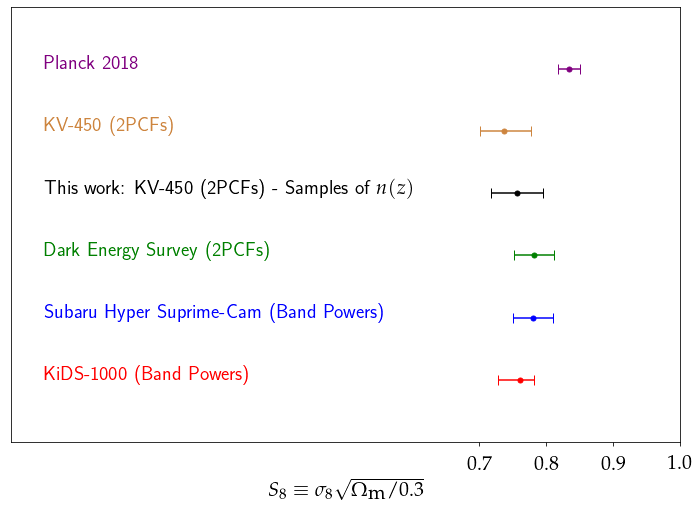

In [8]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.axis([0, 1, 0.5, 4.0])

# KiDS-1000
ax.errorbar(0.761, 1.0, xerr = np.array([[0.033, 0.021]]).T, fmt = 'ro', markersize = 5, capsize=5)
ax.text(0.05, 1.0, 'KiDS-1000 (Band Powers)', size=fontSize, color='red')

# HSC
ax.errorbar(0.780, 1.5, xerr = np.array([[0.030, 0.030]]).T, fmt = 'bo', markersize = 5, capsize=5)
ax.text(0.05, 1.5, 'Subaru Hyper Suprime-Cam (Band Powers)', size=fontSize, color='blue')

# DES
ax.errorbar(0.782, 2.0, xerr = np.array([[0.030, 0.030]]).T, fmt = 'go', markersize = 5, capsize=5)
ax.text(0.05, 2.0, 'Dark Energy Survey (2PCFs)', size=fontSize, color='green')

# this work
# ax.errorbar(0.738, 2.5, xerr = np.array([[0.035, 0.036]]).T, fmt = 'ko', markersize = 5, capsize=5)
# ax.text(0.05, 2.5, 'This work: KV-450 (2PCFs) - Mean of $n(z)$', size=fontSize, color='black')

# this work 0.756 ± (0.039, 0.039)
ax.errorbar(0.756, 2.5, xerr = np.array([[0.039, 0.039]]).T, fmt = 'ko', markersize = 5, capsize=5)
ax.text(0.05, 2.5, 'This work: KV-450 (2PCFs) - Samples of $n(z)$', size=fontSize, color='black')

# KV-450
ax.errorbar(0.737, 3.0, xerr = np.array([[0.036, 0.040]]).T, fmt = 'o', markersize = 5, capsize=5, color = 'peru')
ax.text(0.05, 3.0, 'KV-450 (2PCFs)', size=fontSize, color='peru')

# Planck
ax.errorbar(0.834, 3.5, xerr = np.array([[0.016, 0.016]]).T, fmt = 'o', markersize = 5, capsize=5, color = 'purple')
ax.text(0.05, 3.5, 'Planck 2018', size=fontSize, color='purple')

ax.set_yticks([])
ax.set_xticks([0.7, 0.8, 0.9, 1.0])
ax.set_xlabel(r'$S_{8}\equiv\sigma_{8}\sqrt{\Omega_{\textrm{m}}/0.3}$', fontsize = fontSize, labelpad=10)
ax.tick_params(axis='x', labelsize=fontSize, pad = 10)

# plt.savefig('results/Paper/tensions.pdf', bbox_inches = 'tight')
plt.show()